In [1]:
import deeplake
train_ds= deeplake.load('hub://activeloop/fer2013-train')

c:\Users\ABC\AppData\Local\Programs\Python\Python312\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.16) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



|

hub://activeloop/fer2013-train loaded successfully.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
label_map = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}

def extract_data(dataset):
    images = []
    labels = []
    for sample in dataset:
        img = sample['images']
        lbl = sample['labels']
        images.append(img)
        labels.append(lbl)
    return np.array(images), np.array(labels)

X, y = extract_data(train_ds)

y = np.squeeze(y)
z = np.squeeze(y)

X = X / 255.0
X = np.expand_dims(X, -1) 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=val_ds, epochs=10)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.6019 - loss: 1.0499 - val_accuracy: 0.5761 - val_loss: 1.1021
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.6079 - loss: 1.0389 - val_accuracy: 0.5841 - val_loss: 1.1123
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.6122 - loss: 1.0247 - val_accuracy: 0.5987 - val_loss: 1.1007
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.6120 - loss: 1.0259 - val_accuracy: 0.5827 - val_loss: 1.1338
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.6195 - loss: 1.0132 - val_accuracy: 0.5935 - val_loss: 1.1039
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6155 - loss: 1.0073 - val_accuracy: 0.5935 - val_loss: 1.1022
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6184 - loss: 0.9990 - val_accuracy: 0.5900 - val_loss: 1.1149
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6191 - loss: 1.0065 -

In [24]:
model.evaluate(test_ds)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6119 - loss: 1.0816


[1.0937058925628662, 0.6018808484077454]

In [25]:
predictions = model.predict(test_ds)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


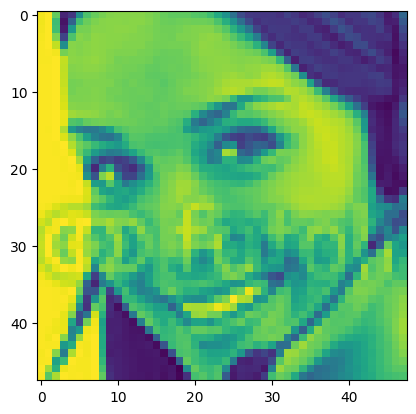

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted label: Happy
True label: Happy


In [29]:
import random
a = random.randint(0, len(y_test) - 1)
image = X_test[a]

plt.imshow(image.squeeze())
plt.show()

image = np.expand_dims(image, axis=0)  
inverse_label_map = {h: k for k, h in label_map.items()}

prediction = model.predict(image)
predicted_label = np.argmax(prediction)
predicted_emotion = inverse_label_map[predicted_label]

print(f'Predicted label: {predicted_emotion}')
print(f'True label: {inverse_label_map[y_test[a]]}')